# Introduccion al problema

En este proyecto se nos presenta como reto estimar los parametros relacionados con la velocidad del viento y potencia generada por un aero-generador, usando el metodo de optimizacion heuristico de Firefly.

La relacion entre el viento y potencia generada esta dada por la siguiente curva. Ver figura 1.



```
# Tiene formato de código

```
# Tiene formato de código

```
# Tiene formato de código
```


```


```

![image.png](attachment:image.png)



El comportamiento observado en la figura 1, se puede aproximar haciendo uso de la siguiente ecuacion.

$$P(\nu ,\theta )=a\left ( \frac{1+be^{\frac{-\nu }{d}}}{1+ce^{\frac{-\nu }{d}}} \right )$$

Para el problema anteriormente descrito, la funcion objetivo es la siguiente.

$$\underset{\theta}{min} \frac{1}{N} \sum_{i=1}^{N}(P_{i}-P(\nu _{i},\theta ))^{2}$$

## Codigo y desarrollo de la solucion

### Importacion de librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Lectura de datos experimentales

In [ ]:
df = pd.read_csv('datos_optimizacion.csv')
velocidad_del_viento = np.array(df['v (m/s)'])
potencia = np.array(df['P (kW)'])

### Definicion de la funcion objetivo

In [ ]:
def potencia_aproximada(x, v=velocidad_del_viento):
    return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))

In [ ]:
# Función objetivo
def error_cuadratico_medio(x):
    return np.mean((potencia - potencia_aproximada(x)) ** 2)

### Programacion del algoritmo Firefly

#### Explicacion del algoritmo firefly

1. Inicialización: Comienza con una población de soluciones candidatas (fireflies) aleatorias en el espacio de búsqueda. Cada firefly representa una posible solución al problema de optimización.

2. Evaluación: Calcula el valor de aptitud (o función objetivo) de cada firefly en función de su posición en el espacio de búsqueda. Este valor refleja qué tan buena es cada solución candidata.

3. Movimiento de los fireflies: Los fireflies se mueven hacia otros fireflies más brillantes, es decir, fireflies con un valor de aptitud superior. La intensidad de la luz (brillo) de un firefly depende de su valor de aptitud. Los fireflies más brillantes atraen a los fireflies más débiles hacia ellos.

4. Actualización de posición: Los fireflies se actualizan siguiendo una fórmula que tiene en cuenta la posición actual del firefly, la posición del firefly más brillante cercano y algunos parámetros de control. Este proceso de actualización se repite hasta que se cumpla un criterio de parada, como un número máximo de iteraciones o una mejora suficiente en la solución.

5. Exploración y explotación: El algoritmo Firefly equilibra la exploración (busca nuevas soluciones) y la explotación (mejora soluciones existentes) a medida que los fireflies se mueven en el espacio de búsqueda. Esto ayuda a encontrar soluciones óptimas o cercanas a óptimas.

6. Convergencia: Con el tiempo, los fireflies tienden a agruparse alrededor de las soluciones óptimas, lo que conduce a la convergencia hacia una solución de alta calidad.

7. Resultado: El algoritmo devuelve la mejor solución encontrada después de cumplir el criterio de parada.


[Formula para el movimiento de las luciernagas ](http://dspace.ucuenca.edu.ec/bitstream/123456789/31492/1/Articulo%20Academico.pdf)

In [ ]:
class AlgoritmoFirefly:
    # Constructor
    def __init__(self, numero_fireflies, max_generaciones, fobj):
        self.fobj = fobj
        self.numero_fireflies = numero_fireflies # Numero de luciernagas
        self.num_params = 4
        self.max_generaciones = max_generaciones # Numero de iteraciones
        self.alpha = 0.000001
        self.beta0 = 5.0
        self.lb = [2000, 1, 400, 2] # Lower bound
        self.ub = [0, -4, 0, 0] # Upper bound
        self.mejor_error = [] # Mejor error de cada generacion
        self.mejor_solucion_global = None # Mejor solucion global
        self.mejor_solucion = [] # Mejor solucion por iteracion
        self.poblacion = [] # Poblacion de luciernagas

    def inicializar_poblacion(self):
        self.poblacion = np.random.uniform(self.lb, self.ub, size=(self.numero_fireflies, self.num_params)) # genera una matriz de numeros aleatorios entre el lower bound y el upper bound del tamano del numero de luciernagas, cada una con cuatro parametros (100x4)

    def actualizar_fireflies(self):
        nueva_poblacion = self.poblacion.copy()
        # Se calcula la luminosidad de cada luciernaga
        # es un arreglo que almacena los valores de la funcion onjetivo de todas las luciernagas
        error_poblacion = np.array([self.fobj(firefly) for firefly in nueva_poblacion])

        for i in range(len(nueva_poblacion)): # Recorre todos los firefly en la poblacion actual
            error_i = error_poblacion[i]
            error_j = error_poblacion
            # Las mejores luciernagas son aquellas donde el error es menor al error en la luciernaga i, por ende la luciernaga i debe moverse en direccion a las mejores luciernagas
            #genera una tupla, la que contendra los indices de lucierngas cuyo error es menor al de la poblacion i
            mejores_fireflies = np.where(error_i > error_j)
            # Se calcula la distancia entre i y cada una de las luciernagas con mejor luminosidad
            r = np.linalg.norm(nueva_poblacion[i] - nueva_poblacion[mejores_fireflies])
            # beta es la intensidad de atracccion entre las luciernagas, depende de la distancia
            # alpha le introducce aleatoriedad al movimiento para introduccir la exploracion
            beta = self.beta0 * np.exp(-self.alpha * r**2)
            # Cada luciernaga se acerca a otras con mayor luminosidad
            # se actuliza la posicion de la luciernaga i en funcion de beta y la diferencia de la su posicion y las mejores lucierngas
            # axi=0 se debe sumar a lo largo del eje0 es decir alo largo de la filas
            nueva_poblacion[i] += beta * np.sum((nueva_poblacion[mejores_fireflies] - nueva_poblacion[i]), axis=0)
        return nueva_poblacion

    def ejecutar_metodo(self):
        self.inicializar_poblacion()
        for generacion in range(self.max_generaciones):
            self.poblacion = self.actualizar_fireflies()
            # Guarda el valor de la  mejor solucion por iteracion
            self.mejor_solucion.append(self.poblacion[np.argmin([self.fobj(firefly) for firefly in self.poblacion])])
            self.mejor_error.append(np.min([self.fobj(firefly) for firefly in self.poblacion]))
            # Guarda el valor de los parametros de la luciernaga mas brillante
        self.mejor_solucion_global = self.mejor_solucion[np.argmin(self.mejor_error)]
        # self.mejor_solucion = self.poblacion[np.argmin([self.fobj(firefly) for firefly in self.poblacion])]

    def graficar_iteraciones(self, numero_grafica):
        plt.plot(velocidad_del_viento, potencia, 'o', label='Datos')
        # ietera sobre cada solucion de la lista  mejor solucion, cada luciernaga se condirero la mejor de cada genercion
        for solucion in self.mejor_solucion:
            plt.plot(velocidad_del_viento, potencia_aproximada(solucion), label='Aproximación')
        plt.xlabel('Velocidad del viento (m/s)')
        plt.ylabel('Potencia (kW)')
        plt.savefig(f"./graficas/{numero_grafica}.png")

In [ ]:
# Realizar el proceso de optimizacion 10 veces para 100 iteraciones y almacenar los resultados en un matriz.
proceso_optimizacion = 10
soluciones = []
for i in range(10):
    problem = AlgoritmoFirefly(100,100, error_cuadratico_medio)
    problem.ejecutar_metodo()
    # problem.graficar_iteraciones(i+1)
    soluciones.append(problem.mejor_solucion_global)

/tmp/ipykernel_74949/2032489200.py:2: RuntimeWarning: overflow encountered in exp
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))
/tmp/ipykernel_74949/2032489200.py:2: RuntimeWarning: invalid value encountered in divide
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))
/tmp/ipykernel_74949/2032489200.py:2: RuntimeWarning: overflow encountered in multiply
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))


/tmp/ipykernel_1244/2032489200.py:2: RuntimeWarning: overflow encountered in exp
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))
/tmp/ipykernel_1244/2032489200.py:2: RuntimeWarning: invalid value encountered in divide
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))


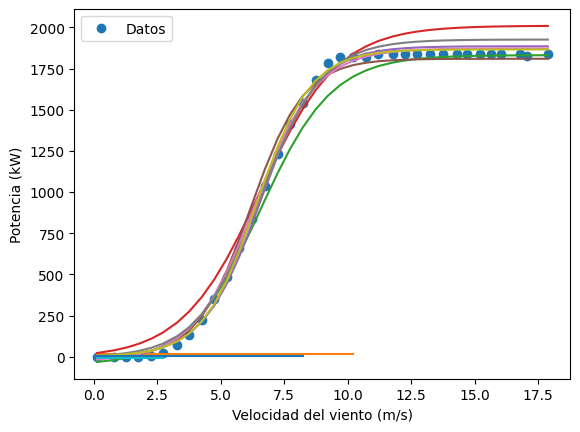

In [ ]:
# Analizar la convergencia del algoritmo graficando las 10 curvas de la funcion objetivo vs el numero de iteraciones.
plt.plot(velocidad_del_viento, potencia, 'o', label='Datos')
for i in range(10):
    plt.plot(velocidad_del_viento, potencia_aproximada(soluciones[i]))
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.show()

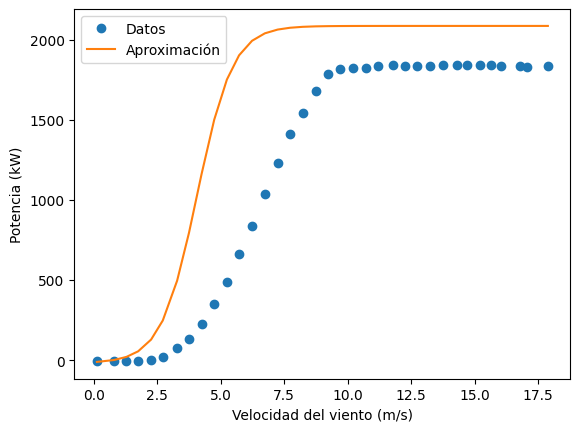

In [ ]:
# Media de las 10 curvas
media = np.mean(soluciones, axis=0)
plt.plot(velocidad_del_viento, potencia, 'o', label='Datos')
plt.plot(velocidad_del_viento, potencia_aproximada(media), label='Aproximación')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.show()

In [ ]:
def minimo_sin_nan(lista):
    minimo = float('inf')
    mejor_solucion = None
    for solucion in soluciones:
        valor = error_cuadratico_medio(solucion)
        if not np.isnan(valor):
            if valor < minimo:
                mejor_solucion = solucion
                minimo = valor
    return minimo, mejor_solucion

la mejor solucion obtenida es [ 1.84806089e+03 -1.87510969e+00  1.99238041e+02  1.19987805e+00] con un valor de aptitud de 966.3118757795261


/tmp/ipykernel_74949/2032489200.py:2: RuntimeWarning: overflow encountered in exp
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))
/tmp/ipykernel_74949/2032489200.py:2: RuntimeWarning: invalid value encountered in divide
  return x[0] * ((1 + x[1] * np.exp(-v / x[3])) / (1 + x[2] * np.exp(-v / x[3])))


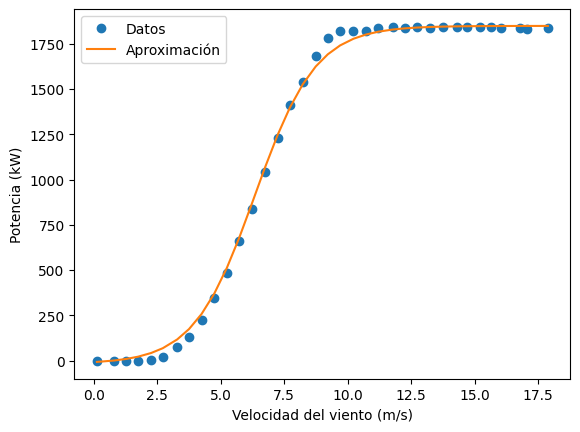

In [ ]:
minimo, mejor_solucion = minimo_sin_nan(soluciones)
print(f"la mejor solucion obtenida es {mejor_solucion} con un valor de aptitud de {minimo}")
plt.plot(velocidad_del_viento, potencia, 'o', label='Datos')
plt.plot(velocidad_del_viento, potencia_aproximada(mejor_solucion), label='Aproximación')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.show()

### Algoritmo PSO

In [ ]:
# PSO
N = 100  # Número de partículas
P = 4   # Dimensionalidad del problema

# Límites
limite_superior = np.array([2000, 1, 400, 2])
limite_inferior = np.array([0, -4, 0, 0])

firefly = np.random.uniform(limite_inferior, limite_superior, size=(N, P))
F = [error_cuadratico_medio(x) for x in firefly]

pbest = firefly.copy()
gbest = firefly[np.argmin(F), :]

Iteraciones = 100
c1, c2 = 0.5, 0.5
Velocidad = np.zeros_like(firefly)

for i in range(Iteraciones):
    r1 = np.random.rand(N, P)
    r2 = np.random.rand(N, P)

    Velocidad += c1 * r1 * (pbest - firefly) + c2 * r2 * (gbest - firefly)
    firefly += Velocidad

    F_old = F.copy()
    F = [error_cuadratico_medio(x) for x in firefly]

    # Actualizar pbest y gbest
    for k in range(N):
        if F[k] < F_old[k]:
            pbest[k, :] = firefly[k, :]

    gbest = firefly[np.argmin(F), :]

print("Parametros optimizados:", gbest, "Error cuadrado medio = ",error_cuadratico_medio(gbest))

Parametros optimizados: [ 1.84979067e+03 -3.52259383e+00  3.54227082e+02  1.08827345e+00] Error cuadrado medio =  421.66363904600416


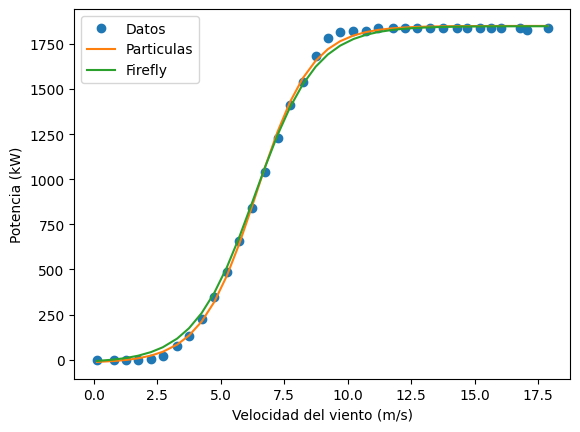

In [ ]:
plt.plot(velocidad_del_viento, potencia, 'o', label='Datos')
plt.plot(velocidad_del_viento, potencia_aproximada( gbest), label='Particulas')
plt.plot(velocidad_del_viento, potencia_aproximada(mejor_solucion), label='Firefly')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Potencia (kW)')
plt.legend()
plt.show()

### Analisis de resultados

1. Para analizar el comportamiento del algoritmo, se realizo el proceso de optimizacion 10 veces, para 100 luciernagas con 100 iteraciones.
2. El algoritmo tiene un tiempo de ejecucion de aproximadamente 8 segundos, incluyendo la creacion de la grafica de iteraciones vs funcion objetivo.
3. Como se puede observar en la grafica, en cada proceso de optimizacion se encuentran soluciones diferentes, unas mejores que otras, esto debido a que la distrubucion de la poblacion es diferente en cada iteracion. Sin embargo, se puede observar que el algoritmo en la mayor parte de los casos ofrece buenas soluciones, esto se puede observar mejor en la grafica de la media de las 10 curvas, dado que no existen cambios abruptos en la curva de comportamiento.
4. El algoritmo PSO ofrece una solucion igual de optima en un menor numero de tiempo.
5. Las soluciones de ambos algoritmos son muy similares como se puede evidenciar en la grafica de las dos soluciones, siendo un poco mejor la solucion del algoritmo PSO
6. Despues de haber realizado refactoring del codigo y utilizar mas las funcionalidades de la libreria numpy, se evidencia una mejora significativa en el rendimiento del algoritmo

### Conclusiones

1. Los algoritmos heurisitcos utilizan estrategias basadas en la experiencia, muchas veces en el comportamiento de los animales para encontrar una solucion a un problema. Estos algoritmos guian la busqueda de soluciones y utilizan estrategias de explotacion y exploracion para encontrar la solucion optima a un problema.
2. La exploracion hace refencia a la capacidad que tiene un algotimos para buscar en nuevas regiones del espacio de busqueda
3. La explotacion se refiere a la capacidad del algoritmos para mejorar soluciones.
4. Los algoritmos heuristicos tienden a ser mas demorados en ejecucion que otros salgoritmos de optimizacion, esto puede ser, debido a que el numero total de la poblacion deber evaluar constantemente la funcion objetivo.
5. El algoritmo de optimizacion Firefly se basa en el comportamiento de las luciernagas para resolver problemas de optimizacion, estos se inspitan en la forma en que las luciernagas atraen a otras luciernagas mediante la emision de luz.
6. En este algoritmo, una luciernaga emite tanta luz como su valor este cerca de ser la solucion optima, es decir, la luciernaga que mas luz provee es la que mas minimiza la funcion objetivo en el caso de problemas de minimizacion
7. el algoritmo firefly depende en gran medida de dos paramtros alpha y beta definidos arbitrariamente, estos parametros hacen referencia a la capacidad de las luciernagas de atraerse entre si y de la incertidumbre en el movimiento de las luciernagas, esto esta relacionado con la explotacion y exploracion respectivamente.
8. La programacion de los algoritmos heuristicos puede tener un costo computacional alto dependiendo del tipo de programacion implementada. por ejemplo, si se tiene un algoritmo con muchas listas y ciclos for anidados el algoritmo va a ser mas lento, se recomienda para la programacion de estos algoritmos utilizar librerias tales como numpy que permitan realizar operaciones matriciales.  